### From FHIR Data to Balanced Neural Network BRCA Subtype Predictions
1. Loading FHIR Data with grip
2. Dimensionality Reduction with Autoencoder
3. Balanced Multimodal Neural Network Training
4. Model Evaluation and Prediction
5. Pathway enrichment analysis
6. Conclusion
   - **Recap**:
    - FHIR and grip enabled loading well-structured molecular data.
    - Autoencoder reduced data dimensionality while preserving key features.
    - A balanced multimodal neural network, trained with SMOTETomek, improved classification accuracy for all subtypes.
   - **Highlight**:
    - Domain-specific expertise played a critical role in subtype classification. 
    - In precision medicine, classifying cancer subtypes is essential for actiionable insights and better outcomes. 
    - This approach bridges biological data and AI, empowering robust subtype prediction workflows and empowering better treatment decisions in real-world scenarios.

### 1. Loading FHIR Data with Grip - TODO

In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, mean_squared_error, silhouette_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import category_encoders as ce
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from tensorflow.keras.callbacks import ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.optim as optim

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

np.random.seed(1234)

import warnings
warnings.filterwarnings('ignore')

# sys.path.append(os.path.abspath("../scripts"))

random_seed = 1234 

#### 1.a Exploratory Data Analysis 

                      BRCA  Labels
BRCA                              
TCGA-3C-AAAU  TCGA-3C-AAAU  BRCA_1
TCGA-3C-AALI  TCGA-3C-AALI  BRCA_4
TCGA-3C-AALJ  TCGA-3C-AALJ  BRCA_2
TCGA-3C-AALK  TCGA-3C-AALK  BRCA_1
TCGA-4H-AAAK  TCGA-4H-AAAK  BRCA_1
Labels
LumA     535
LumB     205
Basal    175
Her2      80
Name: count, dtype: int64


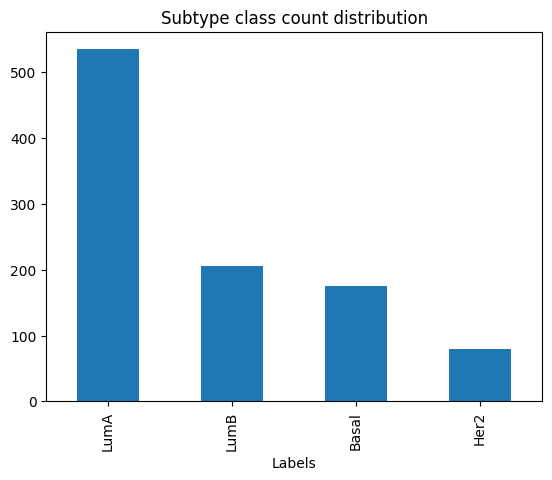

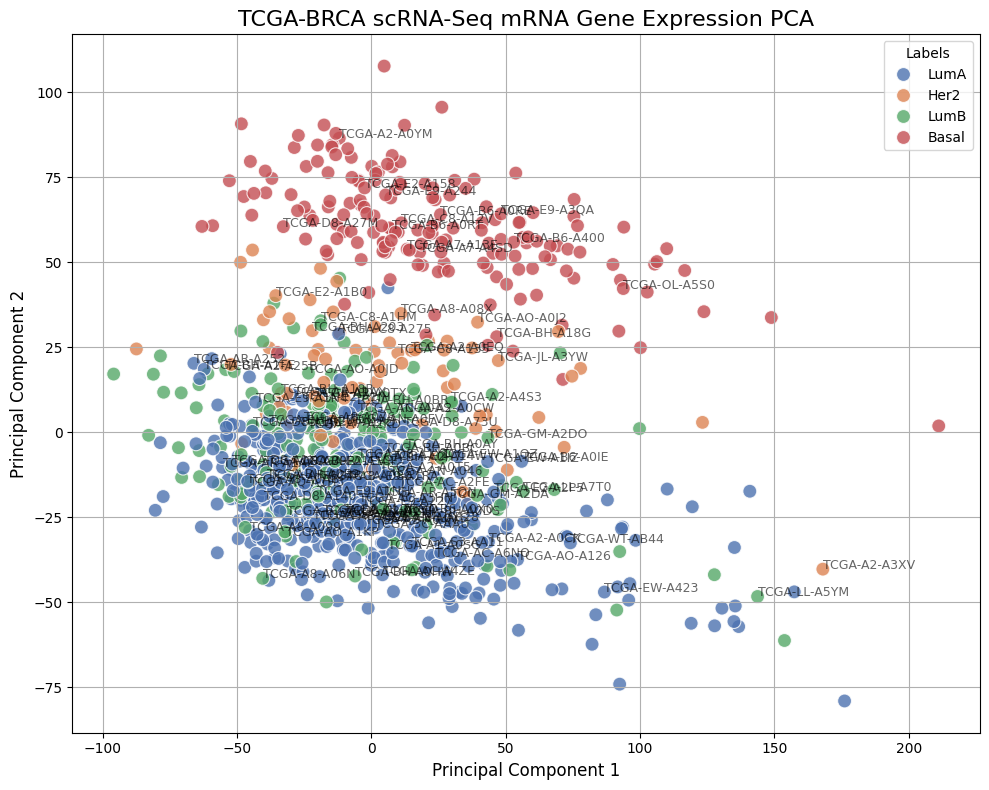

In [2]:
def load_ndjson(path):
    try:
        with open(path, 'r') as file:
            obj = [json.loads(line) for line in file]
            return obj
    except json.JSONDecodeError as e:
        print(e)

def subset_dataframe(df, label_col, ratio, seed):
    grouped = df_expression.groupby(label_col)
    subset = grouped.apply(lambda x: x.sample(frac=ratio, random_state=seed)).reset_index(drop=True)
    return subset

# Load data and subtype label classes -----------------

df = pd.read_csv("../../TMP_20230209/BRCA_v12_20210228.tsv", sep="\t")
df_original = df
# df.dropna(inplace=True) # check for null 

df = df[(~df.iloc[:, 2:].isna().all(axis=1)) & (~(df.iloc[:, 2:] == 0).all(axis=1))]

doc_ref = load_ndjson(path="../../fhir/GDC-FHIR/TCGA-BRCA/META/DocumentReference.ndjson")
patients = load_ndjson(path="../../fhir/GDC-FHIR/TCGA-BRCA/META/Patient.ndjson")
p_map = {}

for patient in patients:
    p_map.update({[_id['value'] for _id in patient['identifier'] if _id['use'] == 'secondary'][0] : patient['id']})
# p_map

# data distribution (pre normalized) -----------------
gexp_cols = [col_name for col_name in list(df.columns) if 'GEXP' in col_name]
df_expression = df[['BRCA', 'Labels'] + gexp_cols]
df_expression.index = df.BRCA
print(df_expression.iloc[:5, :2])

count_per_label = df['Labels'].replace({
    "BRCA_1": "LumA",
    "BRCA_2": "LumB",
    "BRCA_3": "Basal",
    "BRCA_4": "Her2"
  }).value_counts()
print(count_per_label)

count_per_label.plot.bar()
plt.title("Subtype class count distribution")  
plt.show()

# PCA ------------------------------------------------
gene_expression_cols = df_expression.columns[2:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[gene_expression_cols])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

df['Labels'].replace({"BRCA_1": "LumA",
    "BRCA_2": "LumB",
    "BRCA_3": "Basal",
    "BRCA_4": "Her2"}, inplace=True)

plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(
    data=df,
    x='PCA1',
    y='PCA2',
    hue='Labels',
    # palette='viridis',
    palette="deep",
    s=100,
    alpha=0.8
)

for i in range(len(df)):
    if i % 10 == 0:  
        plt.text(
            df['PCA1'].iloc[i],
            df['PCA2'].iloc[i],
            df['BRCA'].iloc[i],
            fontsize=9,
            alpha=0.6
        )

scatter_plot.set_title("TCGA-BRCA scRNA-Seq mRNA Gene Expression PCA", fontsize=16)
scatter_plot.set_xlabel("Principal Component 1", fontsize=12)
scatter_plot.set_ylabel("Principal Component 2", fontsize=12)
plt.legend(title='Labels', loc='upper right', fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()

- Luminal A and Luminal B are both classified as hormone receptor-positive (HR+), meaning they express estrogen and progesterone receptors. 
- Luminal A is usually HER2-negative while Luminal B may be HER2-positive, which can impact treatment options. 
- Basal tumors lack estrogen receptors, making them "triple negative" (ER-, PR-, HER2-) while Luminal cancers are typically hormone receptor positive (ER+) and have a better outlook with hormone therapy options.

### 2. Dimensionality Reduction with Autoencoder
- Reduce feature dimensionality while preserving key molecular characteristics.
- Autoencoders compress the high-dimensional data into a more efficient representation.

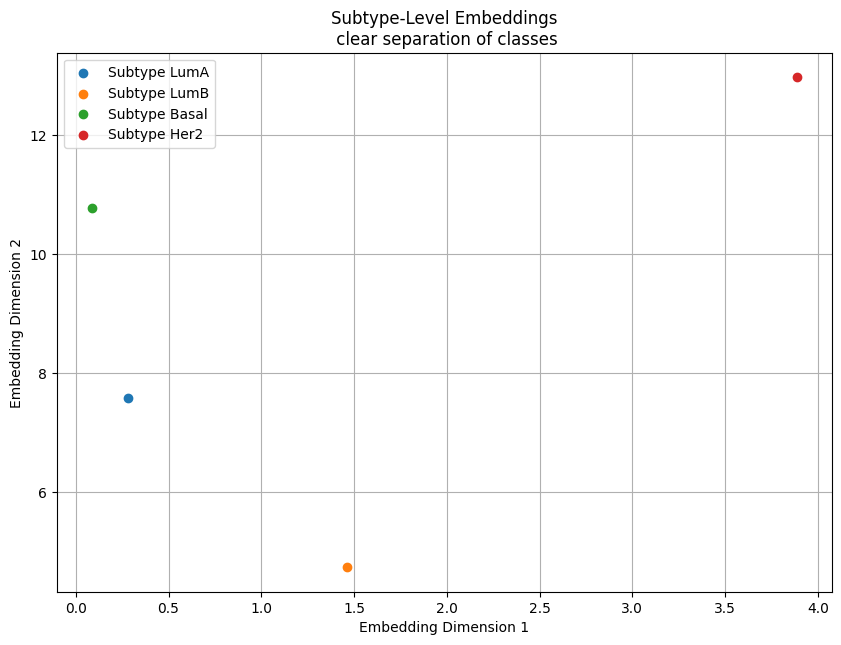

In [3]:
class Autoencoder(nn.Module):
    """Simple autoencoder using torch library to show how the data is transformed into its encoded form."""
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU(), nn.Linear(128, encoding_dim), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(encoding_dim, 128), nn.ReLU(), nn.Linear(128, input_dim), nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
# --------------------------------------
scaler = StandardScaler()
df_expression2 = df_expression
df_expression2[gexp_cols] = scaler.fit_transform(df_expression2[gexp_cols])

class_maps = {"BRCA_1": "LumA", "BRCA_2": "LumB", "BRCA_3": "Basal", "BRCA_4": "Her2" }

X = df_expression2[gexp_cols].values
y = df_expression2["Labels"].values
input_dim = X.shape[1]
encoding_dim = 4  # number of embedding dimensions - here we choose 4 for each subtype

model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

inputs = torch.tensor(X, dtype=torch.float32)
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, inputs)
    loss.backward()
    optimizer.step()
    # print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

encoder = model.encoder
embeddings = encoder(torch.tensor(X, dtype=torch.float32)).detach().numpy()

embedding_cols = ["Dim1", "Dim2", "Dim3", "Dim4"]
df_expression[embedding_cols] = embeddings # add Embeddings to original expression data - aids in dimentionality reduction + prediction
subtype_embeddings = df_expression.groupby("Labels")[embedding_cols].mean()

plt.figure(figsize=(10, 7))
for label, row in subtype_embeddings.iterrows():
    plt.scatter(row["Dim1"], row["Dim2"], label=f"Subtype {class_maps[label]}")
plt.title("Subtype-Level Embeddings\n clear separation of classes")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

### 3. Classify subtypes 
#### 3a. Multimodal Neural Network Training
- When classifying data into multiple subtype categories, only one subtype can be assigned to each patient/specimen data point
- If one class is overrepresented or underrepresented, it might skew the model’s performance. Demo class imbalance in cancer subtype data (e.g., Her2 is underrepresented).

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6892 - loss: 1.1346 - val_accuracy: 0.8375 - val_loss: 1.0081
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8872 - loss: 0.4078 - val_accuracy: 0.8562 - val_loss: 0.8679
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9534 - loss: 0.1750 - val_accuracy: 0.8562 - val_loss: 0.9438
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9664 - loss: 0.1742 - val_accuracy: 0.8813 - val_loss: 0.8579
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9778 - loss: 0.0638 - val_accuracy: 0.8562 - val_loss: 0.9448
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9747 - loss: 0.0792 - val_accuracy: 0.8375 - val_loss: 1.2968
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9743 - loss: 0.0724 - val_accuracy: 0.8687 - val_loss: 0.9572
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9810 - loss: 0.0674 - val_accuracy: 0.8500 - val_loss

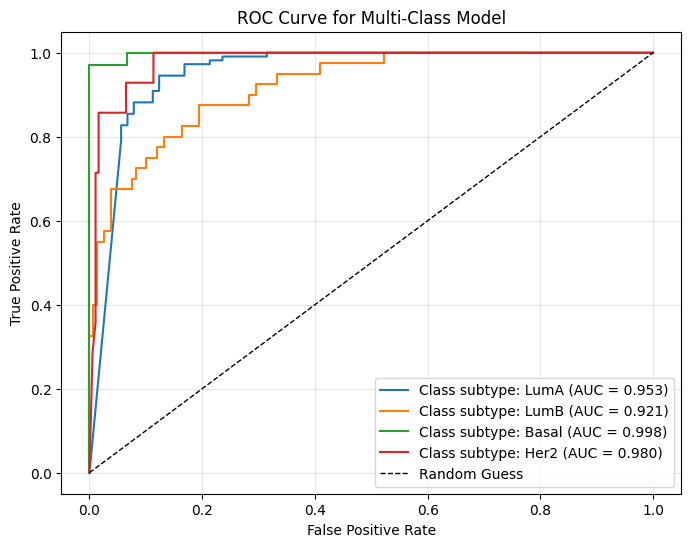

In [4]:
class_maps = {0: "LumA", 1: "LumB", 2: "Basal", 3: "Her2"}

X = df_expression.drop(columns=['Labels', 'BRCA']) 
X = X.apply(pd.to_numeric, errors='coerce').fillna(0) 
y = df_expression['Labels'].astype('category').cat.codes 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=len(class_maps))
y_test = to_categorical(y_test, num_classes=len(class_maps))

def nn_multiclass_model(optimizer='adam', dropout_rate=0.2, hidden_units=32):
    model = Sequential([Dense(hidden_units, activation='relu', input_shape=(X_train.shape[1],)), Dropout(dropout_rate), Dense(hidden_units, activation='relu'),
        Dense(len(class_maps), activation='softmax')  # softmax formula which is an activation for the multi-class scenario
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) # produces a one-hot array containing the probable match for each category
    return model

# training -------------------
optimizer = "adam"
dropout_rate = 0.2
hidden_units = 64
batch_size = 32
epochs = 20

model_nn = nn_multiclass_model(optimizer, dropout_rate, hidden_units)
history = model_nn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)

# evaluation -------------------
test_loss, test_accuracy = model_nn.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.3f}")

# prediction probabilities -----
y_pred_proba = model_nn.predict(X_test)

# ROC curves --------------------
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_maps)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred_proba[:, i])


plt.figure(figsize=(8, 6))
for i in range(len(class_maps)):
    plt.plot(fpr[i], tpr[i], label=f'Class subtype: {class_maps[i]} (AUC = {roc_auc[i]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Model")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

#### 3b. Balanced Multimodal Neural Network Training

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7755 - loss: 1.0491 - val_accuracy: 0.9534 - val_loss: 0.1614 - learning_rate: 0.0010
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9443 - loss: 0.2760 - val_accuracy: 0.9417 - val_loss: 0.3310 - learning_rate: 0.0010
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9482 - loss: 0.2524 - val_accuracy: 0.9534 - val_loss: 0.2936 - learning_rate: 0.0010
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9676 - loss: 0.1926 - val_accuracy: 0.9738 - val_loss: 0.1156 - learning_rate: 0.0010
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9838 - loss: 0.0800 - val_accuracy: 0.9708 - val_loss: 0.1257 - learning_rate: 0.0010
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9810 - loss: 0.1391 - val_accuracy: 0.9621 - val_loss: 0.2813 - learning_rate: 0.0010
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9840 - loss: 0.1442 - val_accuracy:

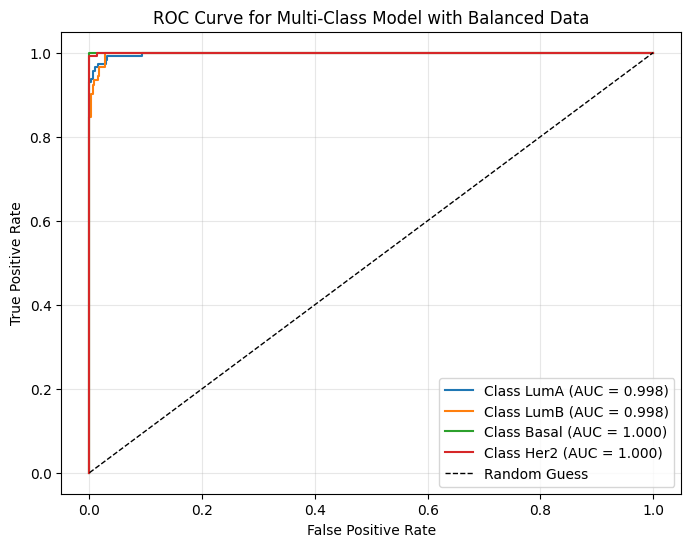

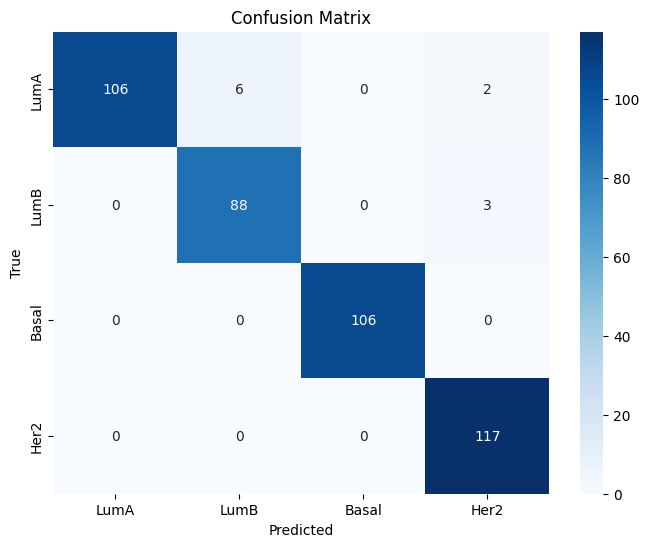


Classification Report:
              precision    recall  f1-score   support

        LumA       1.00      0.93      0.96       114
        LumB       0.94      0.97      0.95        91
       Basal       1.00      1.00      1.00       106
        Her2       0.96      1.00      0.98       117

    accuracy                           0.97       428
   macro avg       0.97      0.97      0.97       428
weighted avg       0.98      0.97      0.97       428



In [5]:
# df_test2 = df_expression.iloc[:, 2:]
# df_test2.reset_index(drop=True, inplace=True)
# df_test2['Labels'] = list(df_expression['Labels'].astype('category').cat.codes)
# df_test = df_test2

# X = df_test.drop(columns=["Labels"]) 
# y = df_test["Labels"].astype("category").cat.codes  

smote_tomek = SMOTETomek(random_state=1234) # 
X_balanced, y_balanced = smote_tomek.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

def w_multiclass_model(optimizer="adam", dropout_rate=0.3, hidden_units=128):
    model = Sequential([Dense(hidden_units, activation="relu", input_shape=(X_train.shape[1],)), 
                        Dropout(dropout_rate), Dense(hidden_units, activation="relu"), Dense(len(np.unique(y_train)), activation="softmax") 
    ])
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

optimizer = "adam"
dropout_rate = 0.3
hidden_units = 128
batch_size = 32
epochs = 30

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1) # 

model = w_multiclass_model(optimizer, dropout_rate, hidden_units)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
                    validation_split=0.2, class_weight=class_weights, callbacks=[lr_scheduler])

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.3f}")

y_pred_proba = model.predict(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_maps)):
    y_true = (y_test == i).astype(int)  
    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_true, y_pred_proba[:, i])

plt.figure(figsize=(8, 6))
for i in range(len(class_maps)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_maps[i]} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Model with Balanced Data")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

y_pred = np.argmax(y_pred_proba, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_maps.values(), yticklabels=class_maps.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_maps.values()))

In [31]:
# from sklearn.metrics import f1_score

# def validation_curve_with_smote(model, X, y, param_range, test_size=0.2):
#     train_f1_scores = []
#     test_f1_scores = []

#     for k_neighbors in param_range:
#         smote = SMOTE(k_neighbors=k_neighbors, random_state=1234)
#         X_resampled, y_resampled = smote.fit_resample(X, y)
#         X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=test_size, random_state=42)

#         y_train_pred = np.argmax(model.predict(X_train), axis=1)
#         y_test_pred = np.argmax(model.predict(X_test), axis=1)

#         train_f1_scores.append(f1_score(y_train, y_train_pred, average="weighted"))
#         test_f1_scores.append(f1_score(y_test, y_test_pred, average="weighted"))

#     return train_f1_scores, test_f1_scores

# param_range = np.arange(1, 21, 2)
# train_scores, test_scores = validation_curve_with_smote(model, X, y, param_range)

# plt.figure(figsize=(8, 6))
# plt.plot(param_range, train_scores, label="Training Accuracy", color="blue")
# plt.plot(param_range, test_scores, label="Validation Accuracy", color="orange")
# plt.xlabel("Number of Neighbors in SMOTE")
# plt.ylabel("Accuracy")
# plt.title("Validation Curve with SMOTE Neighbors")
# plt.legend(loc="best")
# plt.grid(alpha=0.3)
# plt.show()

### 4. Feature Importance and Pathway Enrichment Analysis
Functional interpretation of gene-set "features" per subtype class in a large molecular biology graph (DAG).

In [53]:
output_weights = model_nn.get_weights()[-2]  # last dense
feature_contributions = output_weights.T  # num_classes, hidden_units)

subtype_contributions = pd.DataFrame( feature_contributions, columns=[f"Hidden_{i}" for i in range(feature_contributions.shape[1])], index=[class_maps[i] for i in range(len(class_maps))] )

hidden_to_features = model_nn.get_weights()[0] 
subtype_features = np.dot(hidden_to_features, feature_contributions.T)  

feature_per_subtype_df = pd.DataFrame(subtype_features, index=X.columns, columns=[class_maps[i] for i in range(len(class_maps))])
sorted_feature_per_subtype_df = feature_per_subtype_df.apply(lambda x: x.abs().sort_values(ascending=False))

# print("\nFeature Contributions Per Subtype:")
# print(sorted_feature_per_subtype_df)
# sorted_feature_per_subtype_df.to_csv("feature_contributions_per_subtype.csv")
# -----------
cleaned_df = sorted_feature_per_subtype_df[~sorted_feature_per_subtype_df.index.str.contains("Dim")]
cleaned_df.index = [g.split(":")[3] for g in cleaned_df.index]

subtype_dataframes = {}
for subtype in class_maps.values():
    subtype_df = cleaned_df[[subtype]].reset_index()
    subtype_df.columns = ["Feature", "Importance"]
    subtype_df = subtype_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)
    subtype_dataframes[subtype] = subtype_df

top_n = 30

for subtype, df in subtype_dataframes.items():
    filename = f"subtype_features/{subtype}_feature_contributions.csv"
    df.to_csv(filename, index=False)
    # print(f"Saved {filename}")
    top_features = df.head(top_n)
    l = ",".join(top_features["Feature"])
    print(f"{subtype}, top {top_n} Features:\n{l}\n\n")

LumA, top 30 Features:
EIF4A1,GPR37L1,CCDC63,TAL2,PSMD6,F13B,GJA3,TRA2A,WDR24,FLYWCH2,ABLIM1,SNX31,CNGA2,SH2D4B,ZDHHC11,GABRA2,OR2A7,MYBPC1,MARCO,LGALS3,HIST3H2A,NR1I2,LOC150786,MAP2K7,OSBPL7,C5orf32,COL23A1,C9orf122,ZDHHC6,CDC42SE1


LumB, top 30 Features:
PRMT6,GLYATL1,EID2B,C19orf54,CHST8,SERPINB5,ARF3,LUM,SOHLH1,REG3G,DGCR6,FERMT1,WDR24,ALG1L,DDB1,CBLN3,RAB8A,PEPD,CNIH4,GOLGA2P3,LOC284009,DSCR10,BCAP29,FAHD2A,SAE1,PREX1,TRIM9,ABCC6P1,C1orf63,C7orf72


Basal, top 30 Features:
RNF8,LIPT2,ALX3,IRX4,EPHB3,MOCOS,TTYH1,C22orf34,AQP5,CA8,CDH12,EPHA7,TMEM49,ZIC4,GSG1L,EFHD1,CWC27,KIAA1586,SNORA71D,ROPN1B,ANXA8L1,GPR143,DPEP1,TBC1D22B,GJD4,C1orf204,C6orf106,SOX14,HCG18,FSCN1


Her2, top 30 Features:
MASTL,STK32B,GSG2,DNMT1,SPACA5,ANKRD56,MOV10L1,ANKRD26P1,C1orf201,PSMD3,HIST1H3E,ASPM,RPSAP52,C21orf129,NR0B1,SYNGR4,LIN9,TPX2,C21orf58,CLU,CDC45,LRAT,TAF7L,KDM4A,CDK2,TRIM61,SLITRK5,C5orf47,BRPF1,DCLRE1A




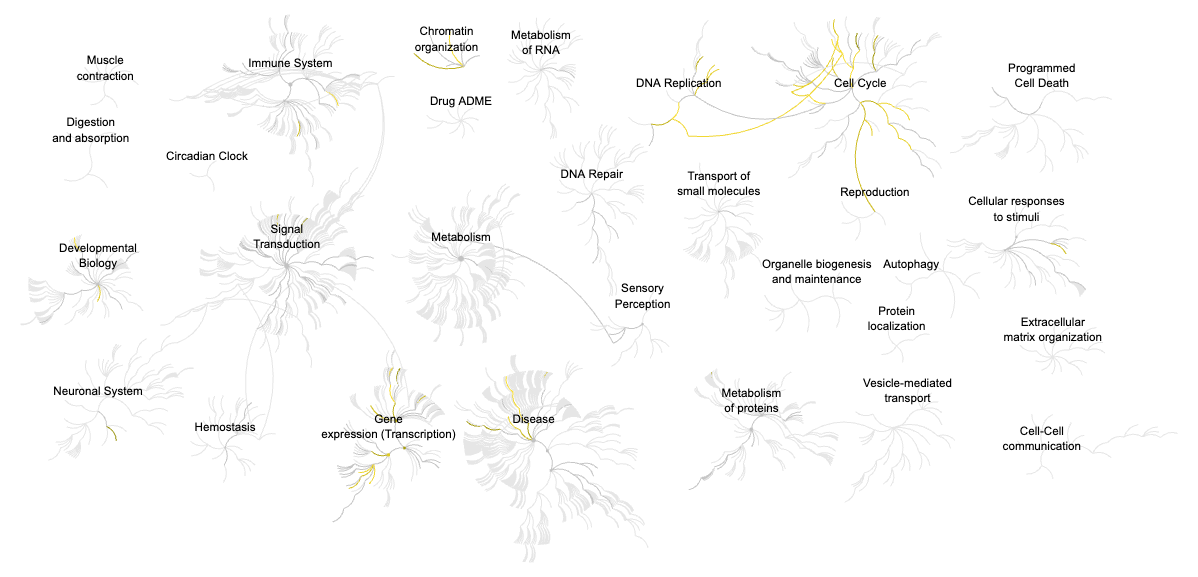

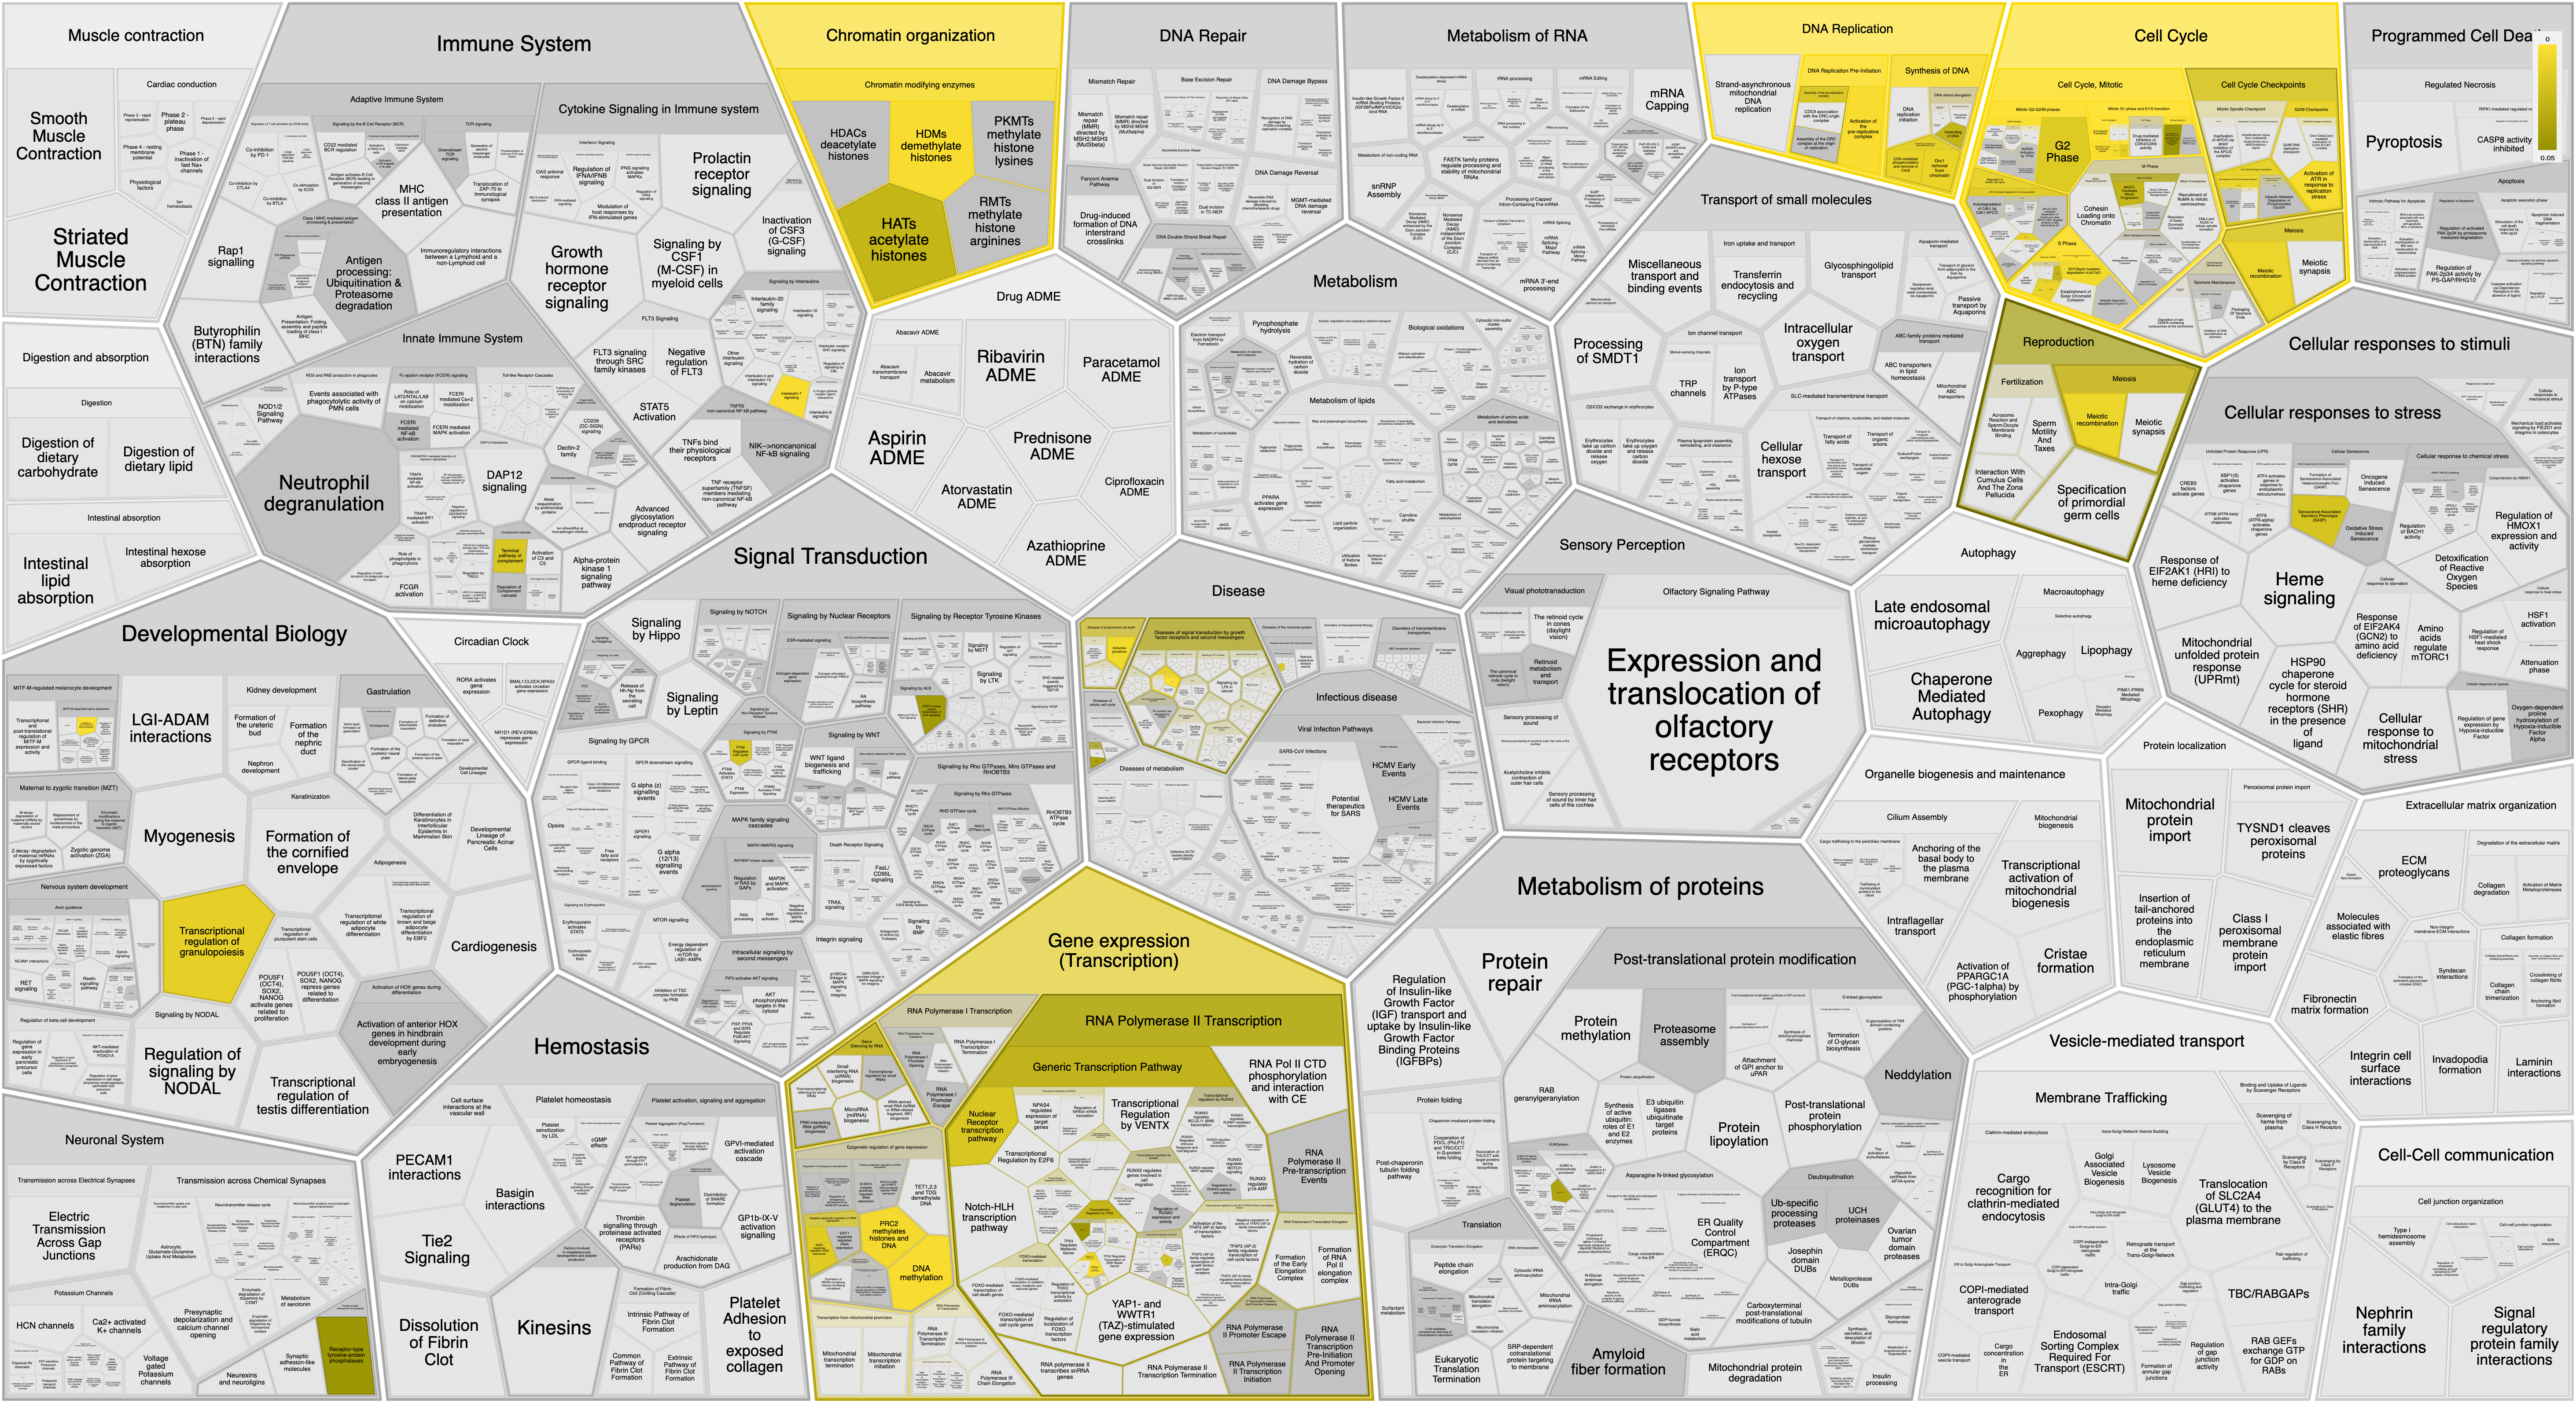

In [50]:
from IPython.display import Image, display
listOfImageNames = ['../img/her2_nn_graph.png',
                    '../img/her2_nn.jpg']
for imageName in listOfImageNames:
    display(Image(filename=imageName))

### **Conclusion**
While the machine learning approach assumes mutually exclusive labels for practical purposes, it incorporates methods (ex. SMOTE, softmax probabilities) that implicitly respect the overlapping nature of biology. By complementing the predictions with pathway analysis and probabilistic interpretations, we can extract meaningful insights that align with biological complexity.